In [2]:
import os
import subprocess
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn import preprocessing
from tqdm.notebook import tqdm  #　for jupyter
# from tqdm import tqdm  # for else

from qiskit import QuantumRegister,ClassicalRegister,QuantumCircuit, execute
from qiskit.visualization import plot_histogram


from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.ml.datasets import ad_hoc_data, breast_cancer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua.algorithms import SklearnSVM
from qiskit.aqua.algorithms import QSVM

from scipy.linalg import norm
import cvxopt
import cvxopt.solvers
from pylab import linspace, scatter, meshgrid, contour, array

import matplotlib.pyplot as plt
import seaborn as sns



seed = 10598
backend = BasicAer.get_backend('qasm_simulator')


In [ ]:
alpha = Parameter("α")
beta = Parameter("β")
gamma = Parameter("γ")
delta = Parameter("δ")

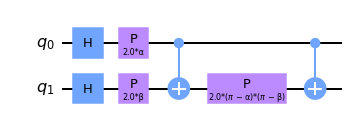

In [13]:
# Implementation from Library
data = [alpha, beta]
ZZFeatureMap(feature_dimension=2, reps=1).assign_parameters(data).draw(output="mpl")


In [17]:
# Implementation from Scratch
def feature_map_zz_dim2(data,rep=2):
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    qc = QuantumCircuit(q,c)
    for i in range(rep):
        qc.h(q)
        # exp(i*a*Z_1)
        qc.rz(-2*data[0],q[0])
        # exp(i*b*Z_2)
        qc.rz(-2*data[1],q[1])
        # exp(i*(π-a)(π-b) Z_1*Z_2)
        qc.cx(0,1)
        qc.rz(-2*(np.pi-data[0])*(np.pi-data[1]),q[1])
        qc.cx(0,1)
    return qc

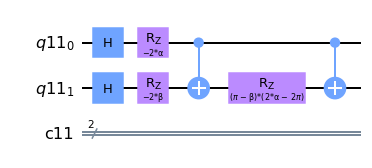

In [18]:
# U(φ) 
# Note that exp(aZ) = rZ(-a*2)
# https://qiskit.org/documentation/locale/ja_JP/tutorials/circuits/3_summary_of_quantum_operations.html

data = [alpha, beta]
feature_map_zz_dim2([alpha,beta],rep=1).draw(output="mpl")

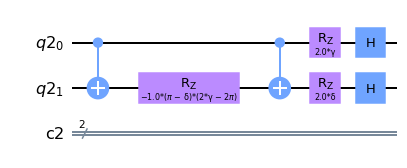

In [5]:
# U†(φ)
data = [alpha, beta]
feature_map_zz_dim2(data,rep=1).inverse().draw(output="mpl")

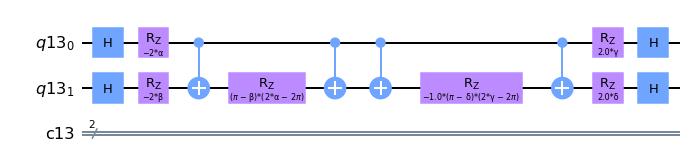

In [19]:
#  U†(φ)U(φ)
data = [alpha, beta]
feature_map_zz_dim2([alpha,beta],rep=1).draw(output="mpl")
qc_u1 = feature_map_zz([alpha,beta],dim=2,rep=1)
qc_u2 =  feature_map_zz([gamma, delta],dim=2,rep=1).inverse()
qc = qc_u1.compose(qc_u2)

qc.draw(output="mpl")

kernel is 0.1875


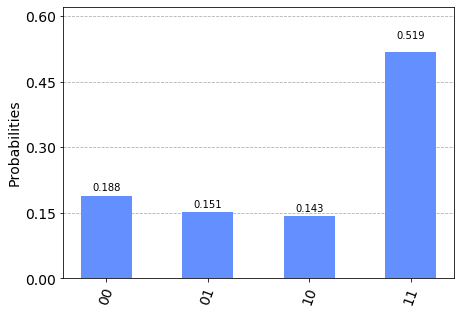

In [21]:
# |<0|U†(φ)U(φ)>|^2
qc_u1 = feature_map_zz([alpha,beta],dim=2,rep=1)
qc_u2 =  feature_map_zz([gamma, delta],dim=2,rep=1).inverse()
qc = qc_u1.compose(qc_u2).assign_parameters({alpha:1,beta:2,gamma:3,delta:4})
qc.measure([0,1],[1,0])
counts = execute(qc, backend , seed_simulator=seed).result().get_counts()
kernel= counts["00"]/sum(counts.values()) if "00" in counts else 0
print(f"kernel is {kernel}")
plot_histogram(counts)

In [24]:
# for dim >= 3
def feature_map_zz(data, dim=2, rep=2):
    q = QuantumRegister(dim)
    c = ClassicalRegister(dim)
    qc = QuantumCircuit(q,c)
    for _ in range(rep):
         # Π_i exp(i*a_i*Z_i) H_i
        for i in range(dim):
            qc.h(q[i])        
            qc.rz(-2*data[i],q[i])
         # Π_(i<j)  exp(i*(π-a_i)(π-a_j) Z_1*Z_2)
        for i in range(dim):
            for j in range(i+1, dim):
                    qc.cx(i, j) 
                    qc.rz(-2*(np.pi-data[i])*(np.pi-data[j]),q[j])
                    qc.cx(i,j)
    return qc



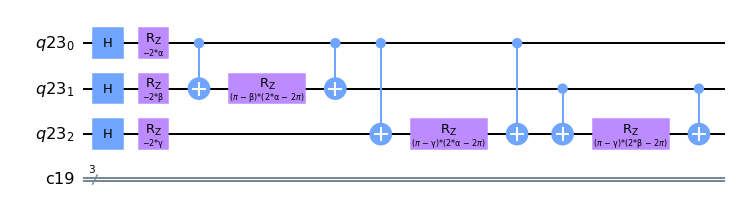

In [25]:
data = [alpha, beta, gamma]
feature_map_zz(data, dim=3,rep=1).draw(output="mpl")

In [26]:
def quantum_kernel(data_1, data_2, rep=2):
    if len(data_1) != len(data_2):
        print("Input size is insconsist")
        raise Exception
    dim = len(data_1)
    qc = feature_map_zz(data_1,dim=dim,rep=rep).compose(feature_map_zz(data_2,dim=dim,rep=rep).inverse())
    qc.measure([0,1],[1,0])
    qc.draw(output="mpl")
    counts = execute(qc, backend , seed_simulator=seed).result().get_counts()
    kernel= counts["00"]/sum(counts.values()) if "00" in counts else 0
    return kernel

kernel is 0.0419921875


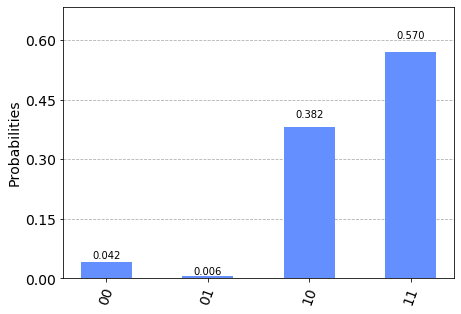

In [27]:
# Quantum Kernel 
qc = feature_map_zz([3,4],dim=2,rep=2).compose(feature_map_zz([1,2],dim=2,rep=2).inverse())
qc.measure([0,1],[1,0])
qc.draw(output="mpl")
counts = execute(qc, backend , seed_simulator=seed).result().get_counts()
kernel= counts["00"]/sum(counts.values()) if "00" in counts else 0
print(f"kernel is {kernel}")
plot_histogram(counts)

# Generate Sample data


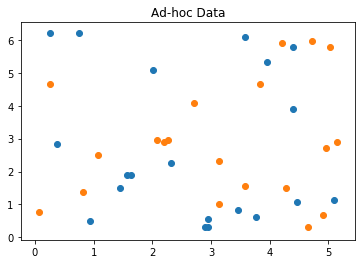

CPU times: user 5.29 s, sys: 14.4 ms, total: 5.3 s
Wall time: 5.31 s


In [28]:
%%time

training_dataset_size=20
testing_dataset_size=10
feature_dim=2
aqua_globals.random_seed = seed
sample_Total, training_input_unnormalized, test_input_unnormalized, class_labels = ad_hoc_data(
    training_size=training_dataset_size, 
    test_size=testing_dataset_size, 
    n=feature_dim, gap=0.3, plot_data=True
)

In [29]:
records = []
for label, data in training_input_unnormalized.items():
    for x, y in data:
        records.append({"x":x, "y":y, "label":label})
df_train = pd.DataFrame(records)

In [30]:
df_train

,x,y,label
0,3.769911,0.628319,A
1,4.398230,5.780530,A
2,2.890265,0.314159,A
3,4.398230,3.895575,A
4,2.953097,0.565487,A
5,3.581416,6.094690,A
6,2.953097,0.314159,A
7,0.251327,6.220353,A
8,0.376991,2.827433,A
9,1.570796,1.884956,A


In [31]:
q_kernel = []
for ind, row in tqdm(df_train.iterrows(),total=len(df_train)):
    q_kernel.append([quantum_kernel(row[:2].values, row_in[:2].values) for ind_in, row_in in df_train.iterrows()])
q_kernel =  np.array(q_kernel)

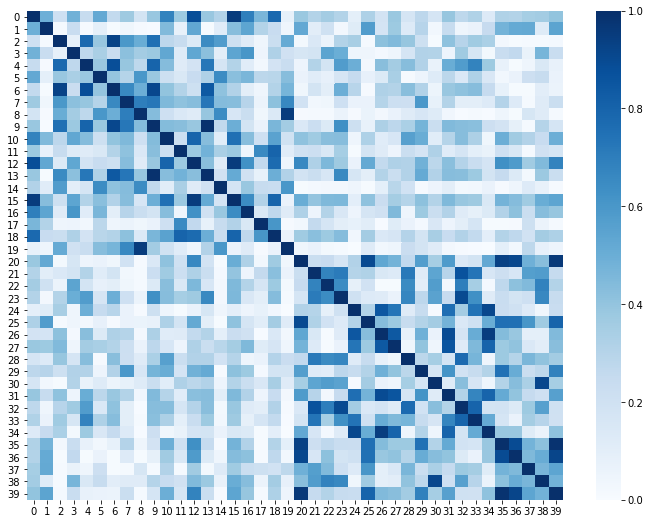

In [33]:
plt.figure(figsize=(12, 9))
sns.heatmap(np.array(q_kernel), annot=False, fmt='g', cmap='Blues')

In [32]:
# Visualize Kernel calculated from Library

CPU times: user 7.98 s, sys: 245 ms, total: 8.23 s
Wall time: 6.38 s


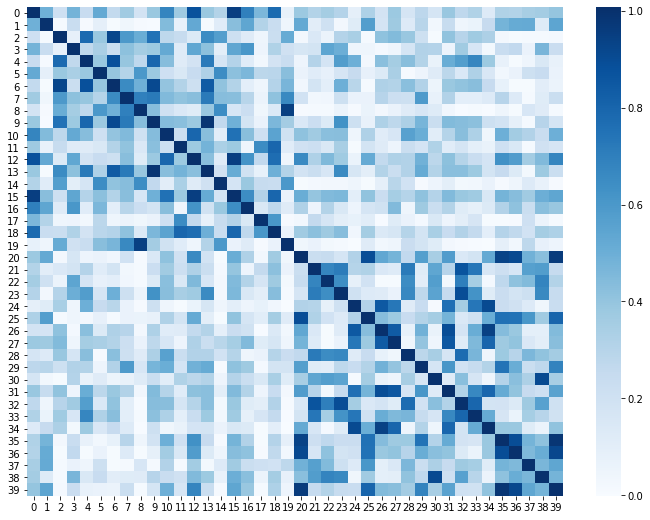

In [34]:
%%time

os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'  # brokeProcessErrorはこれで治るっぽい
shots=1024
# Wall time: 9.47 s for train_size = 20 test_size = 10
backend = BasicAer.get_backend('qasm_simulator')
feature_map = ZZFeatureMap(feature_dim, reps=2)
svm = QSVM(feature_map, training_input_unnormalized, test_input_unnormalized, None)  # the data for prediction can be fed later.
svm.random_seed = seed
quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=seed, seed_transpiler=seed)
result = svm.run(quantum_instance)
kernel_matrix = result['kernel_matrix_training']

plt.figure(figsize=(12, 9))
sns.heatmap(np.array(kernel_matrix), annot=False, fmt='g', cmap='Blues')

diff of kernel value between scratch and library, 0.008418718985919948


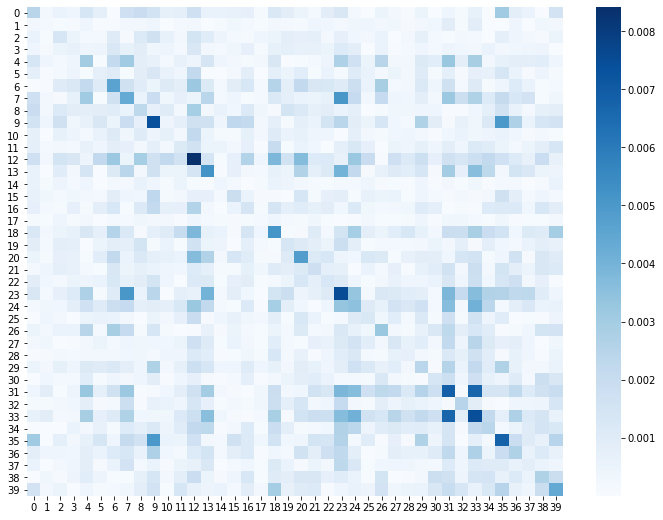

In [35]:
print(f"Difference of kernel value between scratch and library, {abs(kernel_matrix - q_kernel).max()}")
plt.figure(figsize=(12, 9))
sns.heatmap(abs(kernel_matrix - q_kernel), annot=False, fmt='g', cmap='Blues')

# Optimization after Getting Kernel Matrix

In [36]:
# polynominal kernel
power=2
def polynomial_kernel(x, y):
    return (1 + np.dot(x, y)) ** power

poly_kernel = [] 
for i in range(len(df_train)):
    poly_kernel.append(
        [polynomial_kernel(df_train.iloc[i,:2], df_train.iloc[ii,:2]) for ii in range(len(df_train))]
    )
poly_kernel = np.array(poly_kernel)  

In [37]:
%%time

# Gaussian Kernel
sigma = 0.3
# def gaussian_kernel(x, y, sigma):
def gaussian_kernel(x, y):
    return np.exp(-norm(x-y)**2 / (2 * (sigma ** 2)))


g_kernel = [] 
for i in range(len(df_train)):
    g_kernel.append(
#         [gaussian_kernel(df_train.iloc[i,:2], df_train.iloc[ii,:2], sigma=0.5) for ii in range(len(df_train))]
            [gaussian_kernel(df_train.iloc[i,:2], df_train.iloc[ii,:2]) for ii in range(len(df_train))]
    )
g_kernel = np.array(g_kernel)  

CPU times: user 984 ms, sys: 4.07 ms, total: 988 ms
Wall time: 989 ms


In [38]:
# prediction function
def f(x, a, t, X, b, kernel_func):
#     print(x)
    sum_value = 0.0
    for n in range(len(X)):
        sum_value += a[n] * t[n] * kernel_func(x, X[n])
    return sum_value + b
   
def get_laglange_param(t, kernel,print_mode=True):
    # Calculate Lagrange parameter "a" by Quadratic Programming
    N = len(t)
    K = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            K[i, j] = t[i] * t[j] * kernel[i, j]
    
    P = cvxopt.matrix(K)
    q = cvxopt.matrix(-np.ones(N))
    temp1 = np.diag([-1.0]*N)
    temp2 = np.identity(N)
    G = cvxopt.matrix(np.vstack((temp1, temp2)))
    temp1 = np.zeros(N)
    temp2 = np.ones(N) * C
    h = cvxopt.matrix(np.hstack((temp1, temp2)))
    A = cvxopt.matrix(t, (1,N))
    b = cvxopt.matrix(0.0)
    sol = cvxopt.solvers.qp(P=P, q=q, G=G, h=h, A=A, b=b)
    a = array(sol['x']).reshape(N)
    if print_mode:
        print("Lagrange Param")
        print(a)
    
    # extract support vector index
    S = []
    M = []
    for n in range(len(a)):
        if 0 < a[n]:
            S.append(n)
        if 0 < a[n] < C:
            M.append(n)
    
    # Caclulate intercept b
    sum_value = 0
    for n in M:
        temp = 0
        for m in S:
            temp += a[m] * t[m] * kernel[n, m]
        sum_value += (t[n] - temp)
    b = sum_value / len(M)
#     print("Support Vector and Intercept")
#     print(S, b)
    return a, b

def draw_contour(X, t, kernel_func, mesh=30):
    # draw training data 
    for n in range(len(X)):
        if t[n] > 0:
            scatter(X[n,0], X[n,1], c='b', marker='o')
        else:
            scatter(X[n,0], X[n,1], c='r', marker='o')

    # draw support vector
    #    for n in S:
    #        scatter(X[n,0], X[n,1], s=80, c='c', marker='o')
    
    grid_min = X.min() - abs(X.min())*0.1
    grid_max = X.max() + abs(X.max())*0.1
    # draw boundary
    X1, X2 = meshgrid(linspace(grid_min, grid_max,mesh), linspace(grid_min,grid_max,mesh))
    w, h = X1.shape
    X1.resize(X1.size)
    X2.resize(X2.size)
    Z = array([f(array([x1, x2]), a, t, X, b, kernel_func) for (x1, x2) in tqdm(zip(X1, X2),total=len(X1))])
    X1.resize((w, h))
    X2.resize((w, h))
    Z.resize((w, h))
    CS = contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
    plt.show()

In [39]:
kernel_dict = {"gaussian":{"mat":g_kernel, "func":gaussian_kernel},
                         "polynominal": {"mat":poly_kernel, "func":polynomial_kernel},
                         "quantum": {"mat": q_kernel, "func": quantum_kernel}
                        }

## Gaussian Ver

     pcost       dcost       gap    pres   dres
 0: -1.4034e+01 -3.9285e+01  2e+02  4e+00  3e-16
 1: -1.1054e+01 -3.0303e+01  2e+01  5e-16  4e-16
 2: -1.2515e+01 -1.4156e+01  2e+00  1e-15  4e-16
 3: -1.3526e+01 -1.3616e+01  9e-02  2e-16  3e-16
 4: -1.3584e+01 -1.3591e+01  7e-03  2e-15  2e-16
 5: -1.3588e+01 -1.3588e+01  4e-04  6e-16  2e-16
 6: -1.3588e+01 -1.3588e+01  2e-05  4e-16  2e-16
 7: -1.3588e+01 -1.3588e+01  4e-07  1e-15  2e-16
Optimal solution found.
Lagrange Param
[0.5        0.5        0.4999999  0.5        0.5        0.5
 0.20369032 0.5        0.5        0.36572421 0.5        0.5
 0.5        0.49999896 0.5        0.5        0.5        0.5
 0.5        0.5        0.48615509 0.5        0.5        0.5
 0.49999999 0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.49999999 0.49996545
 0.5        0.5        0.5        0.08329286]


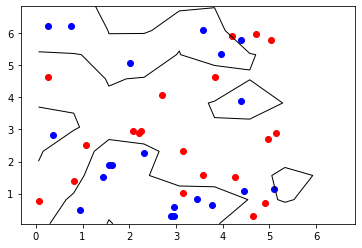

In [43]:
mesh=10
C = 0.5        # hyper-parameter of soft-margin SVM


# load traing dataset as input
N = len(df_train)
data = df_train.iloc[:,0:2].values
label = df_train.iloc[:,2].apply(lambda x: 1.0 if x=="A" else -1.0)
 
# decide the choice of kernel
kernel_choice = kernel_dict["gaussian"]

a, b = get_laglange_param(t=label, kernel=kernel_choice["mat"])
draw_contour(X=data,t=label, kernel_func=kernel_choice["func"],mesh=mesh)


     pcost       dcost       gap    pres   dres
 0: -1.4034e+01 -3.9285e+01  2e+02  4e+00  3e-16
 1: -1.1054e+01 -3.0303e+01  2e+01  5e-16  4e-16
 2: -1.2515e+01 -1.4156e+01  2e+00  1e-15  4e-16
 3: -1.3526e+01 -1.3616e+01  9e-02  2e-16  3e-16
 4: -1.3584e+01 -1.3591e+01  7e-03  2e-15  2e-16
 5: -1.3588e+01 -1.3588e+01  4e-04  6e-16  2e-16
 6: -1.3588e+01 -1.3588e+01  2e-05  4e-16  2e-16
 7: -1.3588e+01 -1.3588e+01  4e-07  1e-15  2e-16
Optimal solution found.
Lagrange Param
[0.5        0.5        0.4999999  0.5        0.5        0.5
 0.20369032 0.5        0.5        0.36572421 0.5        0.5
 0.5        0.49999896 0.5        0.5        0.5        0.5
 0.5        0.5        0.48615509 0.5        0.5        0.5
 0.49999999 0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.49999999 0.49996545
 0.5        0.5        0.5        0.08329286]


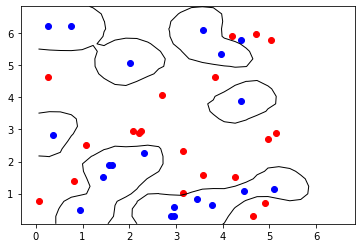

In [42]:
mesh=30
C = 0.5        # hyper-parameter of soft-margin SVM


# load traing dataset as input
N = len(df_train)
data = df_train.iloc[:,0:2].values
label = df_train.iloc[:,2].apply(lambda x: 1.0 if x=="A" else -1.0)
 
# decide the choice of kernel
kernel_choice = kernel_dict["gaussian"]

a, b = get_laglange_param(t=label, kernel=kernel_choice["mat"])
draw_contour(X=data,t=label, kernel_func=kernel_choice["func"],mesh=mesh)


## Quantum Ver

In [ ]:
C = 0.5        # hyper-parameter of soft-margin SVM
mesh = 10

# load traing dataset as input
N = len(df_train)
data = df_train.iloc[:,0:2].values
label = df_train.iloc[:,2].apply(lambda x: 1.0 if x=="A" else -1.0)
 
# decide the choice of kernel
kernel_choice = kernel_dict["quantum"]

a, b = get_laglange_param(t=label, kernel=kernel_choice["mat"])
draw_contour(X=data,t=label, kernel_func=kernel_choice["func"],mesh=mesh)


     pcost       dcost       gap    pres   dres
 0: -1.6261e+01 -4.2721e+01  2e+02  4e+00  9e-16
 1: -9.8006e+00 -3.3896e+01  2e+01  6e-16  1e-15
 2: -1.1119e+01 -1.3550e+01  2e+00  6e-16  7e-16
 3: -1.1991e+01 -1.2431e+01  4e-01  8e-16  7e-16
 4: -1.2189e+01 -1.2259e+01  7e-02  4e-16  9e-16
 5: -1.2226e+01 -1.2231e+01  5e-03  7e-16  8e-16
 6: -1.2229e+01 -1.2229e+01  2e-04  7e-16  8e-16
 7: -1.2229e+01 -1.2229e+01  6e-06  2e-16  9e-16
Optimal solution found.
Lagrange Param
[4.99999717e-01 3.28829011e-01 4.99999973e-01 1.71166050e-01
 4.99999963e-01 4.99999990e-01 4.99999969e-01 5.18658435e-05
 1.55087165e-07 1.76241338e-04 4.99999981e-01 1.11577986e-06
 4.99999985e-01 4.99999986e-01 4.99999965e-01 4.99999973e-01
 4.99999966e-01 4.99999991e-01 4.99999961e-01 4.99999980e-01
 4.99999960e-01 4.18337876e-01 4.99999959e-01 2.19603358e-06
 4.99999749e-01 4.99999987e-01 3.47917999e-06 8.18803814e-02
 8.54638675e-07 4.99999789e-01 4.99999950e-01 4.99999903e-01
 4.99999918e-01 4.99999871e-01 4.

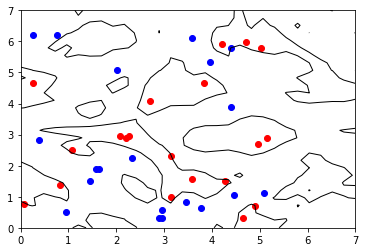

CPU times: user 1h 24min 51s, sys: 20min 36s, total: 1h 45min 28s
Wall time: 2h 30min 7s


In [179]:
C = 0.5        # hyper-parameter of soft-margin SVM
mesh = 10

# load traing dataset as input
N = len(df_train)
data = df_train.iloc[:,0:2].values
label = df_train.iloc[:,2].apply(lambda x: 1.0 if x=="A" else -1.0)
 
# decide the choice of kernel
kernel_choice = kernel_dict["quantum"]

a, b = get_laglange_param(t=label, kernel=kernel_choice["mat"])
draw_contour(X=data,t=label, kernel_func=kernel_choice["func"],mesh=mesh)

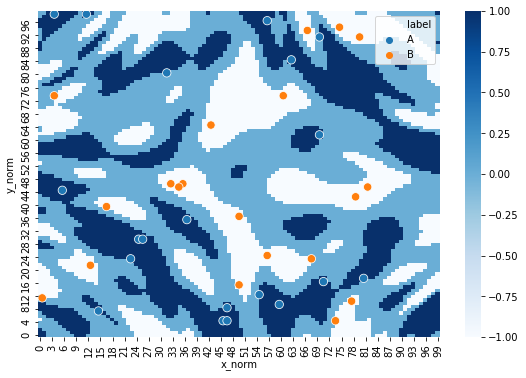

In [30]:
# 正解(Ground Truth)の領域
plt.figure(figsize=(9, 6))
sns.heatmap(np.array(sample_Total).T, annot=False, fmt='g', cmap='Blues').invert_yaxis()
# # plt.scatter(df_train[])
df_train["x_norm"] = df_train["x"].apply(lambda x: x/2/np.pi*100)
df_train["y_norm"] = df_train["y"].apply(lambda x: x/2/np.pi*100)
sns.scatterplot(data=df_train, x="x_norm", y="y_norm",hue="label",s=70)
# plt.show()

# Evaluate Model

In [48]:
records = []
for label, data in test_input_unnormalized.items():
    for x, y in data:
        records.append({"x":x, "y":y, "label":label})
df_test = pd.DataFrame(records)
df_test

,x,y,label
0,0.565487,5.152212,A
1,2.513274,0.188496,A
2,0.439823,0.188496,A
3,4.021239,0.439823,A
4,3.518584,0.816814,A
5,0.691150,0.691150,A
6,1.319469,3.330088,A
7,1.884956,3.455752,A
8,3.769911,0.565487,A
9,3.330088,6.031858,A


In [50]:
# gaussian
kernel_choice = kernel_dict["gaussian"]
data = df_train.iloc[:,:2].values
label = df_train.iloc[:,2].apply(lambda x: 1.0 if x=="A" else -1.0)

a, b = get_laglange_param(t=label, kernel=kernel_choice["mat"])
test_pred_g = array([f(array(row), a, label, data, b, kernel_choice["func"]) for row in tqdm(df_test.iloc[:,:2].values,total=len(df_test))])


df_test["pred_g"] = test_pred_g


     pcost       dcost       gap    pres   dres
 0: -1.4034e+01 -3.9285e+01  2e+02  4e+00  3e-16
 1: -1.1054e+01 -3.0303e+01  2e+01  5e-16  4e-16
 2: -1.2515e+01 -1.4156e+01  2e+00  1e-15  4e-16
 3: -1.3526e+01 -1.3616e+01  9e-02  2e-16  3e-16
 4: -1.3584e+01 -1.3591e+01  7e-03  2e-15  2e-16
 5: -1.3588e+01 -1.3588e+01  4e-04  6e-16  2e-16
 6: -1.3588e+01 -1.3588e+01  2e-05  4e-16  2e-16
 7: -1.3588e+01 -1.3588e+01  4e-07  1e-15  2e-16
Optimal solution found.
Lagrange Param
[0.5        0.5        0.4999999  0.5        0.5        0.5
 0.20369032 0.5        0.5        0.36572421 0.5        0.5
 0.5        0.49999896 0.5        0.5        0.5        0.5
 0.5        0.5        0.48615509 0.5        0.5        0.5
 0.49999999 0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.49999999 0.49996545
 0.5        0.5        0.5        0.08329286]


In [51]:
# polynominal
kernel_choice = kernel_dict["polynominal"]
data = df_train.iloc[:,:2].values
label = df_train.iloc[:,2].apply(lambda x: 1.0 if x=="A" else -1.0)

a, b = get_laglange_param(t=label, kernel=kernel_choice["mat"])
test_pred_p = array([f(array(row), a, label, data, b, kernel_choice["func"]) for row in tqdm(df_test.iloc[:,:2].values,total=len(df_test))])


df_test["pred_p"] = test_pred_p


     pcost       dcost       gap    pres   dres
 0: -2.4271e+01 -4.7494e+01  3e+02  5e+00  8e-13
 1: -1.2021e+01 -3.8705e+01  3e+01  9e-02  7e-13
 2: -1.3330e+01 -1.7094e+01  4e+00  1e-02  5e-13
 3: -1.4641e+01 -1.5334e+01  7e-01  2e-03  6e-13
 4: -1.4850e+01 -1.4956e+01  1e-01  2e-04  7e-13
 5: -1.4886e+01 -1.4912e+01  3e-02  4e-05  6e-13
 6: -1.4896e+01 -1.4902e+01  6e-03  8e-06  8e-13
 7: -1.4899e+01 -1.4899e+01  4e-04  1e-15  8e-13
 8: -1.4899e+01 -1.4899e+01  1e-05  4e-16  9e-13
Optimal solution found.
Lagrange Param
[4.99999767e-01 4.99999913e-01 2.19786004e-07 4.99999963e-01
 4.98928778e-01 4.99996573e-01 2.29605336e-07 2.55749867e-06
 4.99999957e-01 4.99999925e-01 4.99999923e-01 4.99999874e-01
 4.99998794e-01 4.99999924e-01 4.99999906e-01 4.99999933e-01
 4.99999935e-01 2.54798744e-07 4.99999802e-01 4.99999956e-01
 4.99999188e-01 4.99999841e-01 4.99999916e-01 4.99999155e-01
 6.81638170e-08 3.60101624e-01 2.88855305e-01 4.99999876e-01
 4.99999720e-01 3.13837405e-01 4.99999561e-01

In [52]:
# quantum
kernel_choice = kernel_dict["quantum"]
data = df_train.iloc[:,:2].values
label = df_train.iloc[:,2].apply(lambda x: 1.0 if x=="A" else -1.0)

a, b = get_laglange_param(t=label, kernel=kernel_choice["mat"])
test_pred_q = array([f(array(row), a, label, data, b, kernel_choice["func"]) for row in tqdm(df_test.iloc[:,:2].values,total=len(df_test))])


df_test["pred_q"] = test_pred_q


     pcost       dcost       gap    pres   dres
 0: -6.6195e+00 -3.2162e+01  1e+02  3e+00  3e-16
 1: -5.8688e+00 -2.3288e+01  2e+01  4e-16  4e-16
 2: -6.3244e+00 -8.1191e+00  2e+00  1e-16  4e-16
 3: -6.8881e+00 -7.2596e+00  4e-01  8e-16  5e-16
 4: -7.0238e+00 -7.0923e+00  7e-02  2e-16  4e-16
 5: -7.0518e+00 -7.0607e+00  9e-03  5e-16  4e-16
 6: -7.0555e+00 -7.0559e+00  4e-04  4e-16  4e-16
 7: -7.0556e+00 -7.0557e+00  1e-05  2e-15  4e-16
 8: -7.0556e+00 -7.0556e+00  2e-07  7e-16  4e-16
Optimal solution found.
Lagrange Param
[2.51038711e-09 4.99999999e-01 4.99999994e-01 4.64709226e-01
 4.99999999e-01 5.77246300e-09 1.60822009e-08 1.59506362e-09
 1.89399157e-09 1.09471141e-01 4.99999991e-01 4.99999965e-01
 4.99999997e-01 4.99999994e-01 4.54102318e-09 4.99999995e-01
 4.99999987e-01 4.18223969e-01 7.80088970e-09 4.99999986e-01
 1.18850931e-08 1.08716690e-09 4.99999997e-01 4.99999998e-01
 4.94392308e-09 3.50711845e-01 4.26061145e-01 4.99999998e-01
 4.99999994e-01 4.99999999e-01 4.99999904e-01

In [53]:
df_test

,x,y,label,pred_g,pred_p,pred_q
0,0.565487,5.152212,A,-0.096395,0.091029,0.030786
1,2.513274,0.188496,A,0.321576,2.078905,0.873018
2,0.439823,0.188496,A,0.005856,1.399000,1.403786
3,4.021239,0.439823,A,0.263573,0.990231,1.053747
4,3.518584,0.816814,A,0.627001,0.756279,1.224935
5,0.691150,0.691150,A,0.176046,0.798123,0.652803
6,1.319469,3.330088,A,-0.045794,-0.649387,0.456991
7,1.884956,3.455752,A,-0.190002,-0.515379,0.230357
8,3.769911,0.565487,A,0.668612,0.971552,1.404014
9,3.330088,6.031858,A,0.316055,1.344614,1.012408


# Breast Cancer Dataset

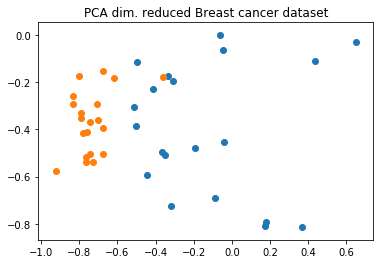

CPU times: user 1.1 s, sys: 25 ms, total: 1.12 s
Wall time: 154 ms


In [3]:
%%time

training_dataset_size=20
testing_dataset_size=10
feature_dim=2
aqua_globals.random_seed = seed
sample_Total, training_input_unnormalized_br, test_input_unnormalized_br, class_labels = breast_cancer(
    training_size=training_dataset_size, 
    test_size=testing_dataset_size, 
    n=feature_dim, plot_data=True
)

In [49]:
records = []
for label, data in training_input_unnormalized_br.items():
    for x, y in data:
        records.append({"x":x, "y":y, "label":label})
df_train_br = pd.DataFrame(records)

q_kernel_br = []
for ind, row in tqdm(df_train_br.iterrows(),total=len(df_train)):
    q_kernel_br.append([quantum_kernel(row[:2].values, row_in[:2].values) for ind_in, row_in in df_train_br.iterrows()])
q_kernel_br =  np.array(q_kernel_br)

In [50]:
poly_kernel_br = [] 
for i in range(len(df_train_br)):
    poly_kernel_br.append(
        [polynomial_kernel(df_train_br.iloc[i,:2], df_train_br.iloc[ii,:2]) for ii in range(len(df_train_br))]
    )
poly_kernel_br = np.array(poly_kernel_br)  

g_kernel_br = [] 
for i in range(len(df_train_br)):
    g_kernel_br.append(
#         [gaussian_kernel(df_train_br.iloc[i,:2], df_train_br.iloc[ii,:2], sigma=0.5) for ii in range(len(df_train_br))]
            [gaussian_kernel(df_train_br.iloc[i,:2], df_train_br.iloc[ii,:2]) for ii in range(len(df_train_br))]
    )
g_kernel_br = np.array(g_kernel_br)  

In [51]:
records = []
for label, data in test_input_unnormalized_br.items():
    for x, y in data:
        records.append({"x":x, "y":y, "label":label})
df_test_br = pd.DataFrame(records)


kernel_dict = {"gaussian":{"mat":g_kernel_br, "func":gaussian_kernel},
                         "polynominal": {"mat":poly_kernel_br, "func":polynomial_kernel},
                         "quantum": {"mat": q_kernel_br, "func": quantum_kernel}
                        }

# quantum
kernel_choice = kernel_dict["quantum"]
data = df_train_br.iloc[:,:2].values
label = df_train_br.iloc[:,2].apply(lambda x: 1.0 if x=="A" else -1.0)

a, b = get_laglange_param(X=data,t=label, kernel=kernel_choice["mat"])
test_pred_q = array([f(array(row), a, label, data, b, kernel_choice["func"]) for row in tqdm(df_test_br.iloc[:,:2].values,total=len(df_test_br))])


df_test_br["pred_q"] = test_pred_q

# gaussian
kernel_choice = kernel_dict["gaussian"]
data = df_train_br.iloc[:,:2].values
label = df_train_br.iloc[:,2].apply(lambda x: 1.0 if x=="A" else -1.0)

a, b = get_laglange_param(X=data,t=label, kernel=kernel_choice["mat"])
test_pred_g = array([f(array(row), a, label, data, b, kernel_choice["func"]) for row in tqdm(df_test_br.iloc[:,:2].values,total=len(df_test_br))])


df_test_br["pred_g"] = test_pred_g

# polynominal
kernel_choice = kernel_dict["polynominal"]
data = df_train_br.iloc[:,:2].values
label = df_train_br.iloc[:,2].apply(lambda x: 1.0 if x=="A" else -1.0)

a, b = get_laglange_param(X=data,t=label, kernel=kernel_choice["mat"])
test_pred_p = array([f(array(row), a, label, data, b, kernel_choice["func"]) for row in tqdm(df_test_br.iloc[:,:2].values,total=len(df_test_br))])


df_test_br["pred_p"] = test_pred_p

df_test_br

     pcost       dcost       gap    pres   dres
 0: -1.6261e+01 -4.2721e+01  2e+02  4e+00  9e-16
 1: -9.8006e+00 -3.3896e+01  2e+01  6e-16  1e-15
 2: -1.1119e+01 -1.3550e+01  2e+00  6e-16  7e-16
 3: -1.1991e+01 -1.2431e+01  4e-01  8e-16  7e-16
 4: -1.2189e+01 -1.2259e+01  7e-02  4e-16  9e-16
 5: -1.2226e+01 -1.2231e+01  5e-03  7e-16  8e-16
 6: -1.2229e+01 -1.2229e+01  2e-04  7e-16  8e-16
 7: -1.2229e+01 -1.2229e+01  6e-06  2e-16  9e-16
Optimal solution found.
Lagrange Param
[4.99999717e-01 3.28829011e-01 4.99999973e-01 1.71166050e-01
 4.99999963e-01 4.99999990e-01 4.99999969e-01 5.18658435e-05
 1.55087165e-07 1.76241338e-04 4.99999981e-01 1.11577986e-06
 4.99999985e-01 4.99999986e-01 4.99999965e-01 4.99999973e-01
 4.99999966e-01 4.99999991e-01 4.99999961e-01 4.99999980e-01
 4.99999960e-01 4.18337876e-01 4.99999959e-01 2.19603358e-06
 4.99999749e-01 4.99999987e-01 3.47917999e-06 8.18803814e-02
 8.54638675e-07 4.99999789e-01 4.99999950e-01 4.99999903e-01
 4.99999918e-01 4.99999871e-01 4.


     pcost       dcost       gap    pres   dres
 0: -7.0511e+00 -4.1967e+01  3e+02  5e+00  5e-16
 1: -4.3307e+00 -3.2479e+01  3e+01  6e-16  6e-16
 2: -4.9028e+00 -8.1638e+00  3e+00  3e-16  5e-16
 3: -5.5998e+00 -6.3486e+00  7e-01  1e-15  4e-16
 4: -5.7942e+00 -5.9394e+00  1e-01  1e-15  4e-16
 5: -5.8489e+00 -5.8613e+00  1e-02  4e-16  3e-16
 6: -5.8530e+00 -5.8535e+00  5e-04  2e-16  4e-16
 7: -5.8532e+00 -5.8532e+00  1e-05  2e-16  5e-16
 8: -5.8532e+00 -5.8532e+00  1e-07  4e-16  5e-16
Optimal solution found.
Lagrange Param
[1.10903341e-09 9.06616526e-09 5.00000000e-01 1.13414736e-08
 3.53249342e-01 4.99999999e-01 4.99999999e-01 7.32615124e-06
 1.06093210e-01 1.47564321e-02 3.50596007e-01 1.44167620e-01
 4.25891867e-01 3.57300253e-01 2.00866662e-09 4.99999999e-01
 5.00000000e-01 2.37856149e-02 2.16130892e-09 2.49507247e-09
 1.29920042e-01 1.75962967e-09 4.99999931e-01 1.28038122e-09
 4.99999999e-01 4.99999999e-01 1.21171964e-09 1.26909940e-09
 1.49045809e-09 1.86493887e-09 3.23320548e-0


     pcost       dcost       gap    pres   dres
 0: -9.3807e+00 -3.7617e+01  2e+02  4e+00  1e-15
 1: -5.4570e+00 -2.8362e+01  3e+01  2e-01  2e-15
 2: -5.7332e+00 -8.8163e+00  3e+00  2e-02  1e-15
 3: -6.7925e+00 -7.4308e+00  7e-01  3e-03  1e-15
 4: -6.9988e+00 -7.2117e+00  2e-01  7e-04  2e-15
 5: -7.0892e+00 -7.1126e+00  2e-02  3e-05  1e-15
 6: -7.0995e+00 -7.1004e+00  9e-04  7e-07  2e-15
 7: -7.1000e+00 -7.1000e+00  3e-05  1e-08  2e-15
 8: -7.1000e+00 -7.1000e+00  5e-07  1e-10  2e-15
Optimal solution found.
Lagrange Param
[1.96332992e-09 1.11585177e-09 4.99999998e-01 1.21922224e-09
 4.99999990e-01 4.99999997e-01 4.99999996e-01 5.12880152e-10
 1.29742817e-09 5.12231101e-10 4.99999976e-01 4.92146066e-10
 3.75330055e-10 4.31746198e-10 1.05052439e-09 4.99999998e-01
 4.99999998e-01 4.99960609e-01 4.99999983e-01 4.99999552e-01
 4.45391137e-09 2.45175035e-09 4.99999993e-01 4.00409220e-09
 4.99999996e-01 4.99999997e-01 3.79021667e-09 3.73027543e-09
 5.28275695e-09 4.99999962e-01 9.76127884e-1

,x,y,label,pred_q,pred_g,pred_p
0,-0.103898,0.179248,A,1.667739,0.819567,1.309670
1,-0.530864,-0.457307,A,-0.155607,0.073109,-0.222972
2,-0.210400,-0.424927,A,0.926252,1.369297,1.066187
3,-0.021150,-0.468933,A,0.791680,1.234316,1.707608
4,-0.208184,-0.487275,A,1.099681,1.354076,1.088123
5,0.157078,-0.476244,A,0.049546,1.044874,2.214529
6,0.116275,0.720881,A,0.342349,0.542134,1.735123
7,-0.068440,-0.523605,A,1.166646,1.272920,1.579304
8,-0.544330,-0.513921,A,-0.489345,0.028090,-0.287809
9,-0.310342,-0.539510,A,0.671727,1.176653,0.712117


In [52]:
# Comparison against Library

os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'  # brokeProcessError can be fix by this command
shots=1024
# Wall time: 9.47 s for train_size = 20 test_size = 10
backend = BasicAer.get_backend('qasm_simulator')
feature_map = ZZFeatureMap(feature_dim, reps=2)
svm = QSVM(feature_map, training_input_unnormalized_br, test_input_unnormalized_br, None)  # the data for prediction can be fed later.
svm.random_seed = seed
quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=seed, seed_transpiler=seed)
result = svm.run(quantum_instance)
kernel_matrix = result['kernel_matrix_training']
print("breast cancer/Accuracy: ", result["testing_accuracy"])

svm = QSVM(feature_map, training_input_unnormalized, test_input_unnormalized, None)  # the data for prediction can be fed later.
svm.random_seed = seed
quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=seed, seed_transpiler=seed)
result = svm.run(quantum_instance)
kernel_matrix = result['kernel_matrix_training']
print("Ad hoc/Accuracy: ", result["testing_accuracy"])

breast cancer/Accuracy:  0.75
Ad hoc/Accuracy:  1.0


In [54]:
# breast Cancer Result
pred_q_lib = svm.predict(df_test_br.iloc[:,:2].values)

df_test_br["pred_q_lib"] = pred_q_lib
df_test_br

,x,y,label,pred_q,pred_g,pred_p,pred_q_lib
0,-0.103898,0.179248,A,1.667739,0.819567,1.309670,0
1,-0.530864,-0.457307,A,-0.155607,0.073109,-0.222972,1
2,-0.210400,-0.424927,A,0.926252,1.369297,1.066187,0
3,-0.021150,-0.468933,A,0.791680,1.234316,1.707608,0
4,-0.208184,-0.487275,A,1.099681,1.354076,1.088123,0
5,0.157078,-0.476244,A,0.049546,1.044874,2.214529,0
6,0.116275,0.720881,A,0.342349,0.542134,1.735123,1
7,-0.068440,-0.523605,A,1.166646,1.272920,1.579304,0
8,-0.544330,-0.513921,A,-0.489345,0.028090,-0.287809,1
9,-0.310342,-0.539510,A,0.671727,1.176653,0.712117,1


In [62]:
# Accuracy of QSVM scractch
# breast Cancer accuracy 
print("breast cancer/Accuracy: ",
         df_test_br.apply(lambda x: (x["label"] =="A" and x["pred_q"] >0) or (x["label"] =="B" and x["pred_q"] < 0), axis=1).sum()/len(df_test_br))
# ad_hoc accuracy 
print("breast cancer/Accuracy: ",
          df_test.apply(lambda x: (x["label"] =="A" and x["pred_q"] >0) or (x["label"] =="B" and x["pred_q"] < 0), axis=1).sum()/len(df_test))

breast cancer/Accuracy:  0.7
breast cancer/Accuracy:  1.0


# Periodic Data

In [ ]:
# I expect QSVM can classify periodic boundary well
# It turned out to be not the case...

In [56]:
import random
periodic_data = np.zeros((100,100))
flip_lists = sum([list(range(i*10, i*10+10)) for i in  range(0,10, 2)],[])
periodic_data[: , flip_lists] = 1

training_data_num = 40
test_data_num = 40

random.seed(1)
random_ind_x = random.sample(range(100),training_data_num + test_data_num)
random_ind_y = random.sample(range(100),training_data_num + test_data_num)
traing_data_label = periodic_data[random_ind_x, random_ind_y]
df_period = pd.DataFrame({"x":np.array(random_ind_x)/100*2*np.pi, "y": np.array(random_ind_y)/100*2*np.pi, "label": traing_data_label})
df_period_train = df_period[:training_data_num].copy()
df_period_test = df_period[training_data_num:].copy()

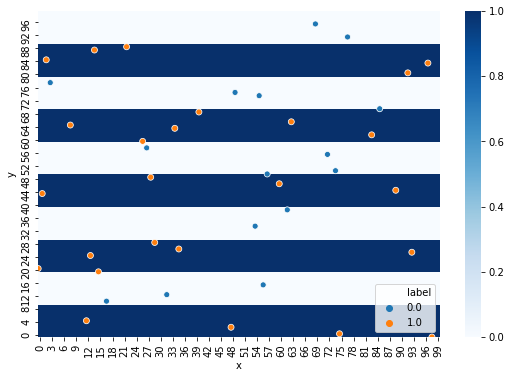

In [57]:
plt.figure(figsize=(9, 6))
sns.heatmap(periodic_data.T, annot=False, fmt='g', cmap='Blues').invert_yaxis()

df_plot = df_period_train.copy()
df_plot["x"] = df_plot["x"]*100/2/np.pi
df_plot["y"] = df_plot["y"]*100/2/np.pi
sns.scatterplot(data=df_plot, x="x", y="y", hue="label")

In [58]:
training_input_pr = {"A": df_period_train.query("label == 0").iloc[:,:2].values, "B": df_period_train.query("label == 0").iloc[:,:2].values}
test_input_pr = {"A": df_period_test.query("label == 0").iloc[:,:2].values,  "B": df_period_test.query("label == 0").iloc[:,:2].values}

## Gaussian Ver

In [59]:
from qiskit.aqua.algorithms import SklearnSVM

result = SklearnSVM(training_input_pr, test_input_pr,df_test.iloc[:,:2].values,  gamma=0.7).run()

print(result["testing_accuracy"])
result["predicted_labels"]

0.5


array([0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0.])

In [60]:
sigma=0.3
g_kernel_pr = [] 
for i in range(len(df_period_train)):
    g_kernel_pr.append(
            [gaussian_kernel(df_period_train.iloc[i,:2], df_period_train.iloc[ii,:2]) for ii in range(len(df_period_train))]
    )
g_kernel_pr = np.array(g_kernel_pr)  
g_kernel_pr 

array([[1.00000000e+000, 7.90721570e-049, 1.90365327e-112, ...,
        2.98824754e-006, 2.75230052e-057, 6.46988043e-059],
       [7.90721570e-049, 1.00000000e+000, 3.79378158e-014, ...,
        8.90086274e-022, 1.59833869e-042, 6.52016735e-035],
       [1.90365327e-112, 3.79378158e-014, 1.00000000e+000, ...,
        2.74255100e-068, 1.69387655e-066, 1.52383267e-054],
       ...,
       [2.98824754e-006, 8.90086274e-022, 2.74255100e-068, ...,
        1.00000000e+000, 2.27170179e-040, 5.96482563e-039],
       [2.75230052e-057, 1.59833869e-042, 1.69387655e-066, ...,
        2.27170179e-040, 1.00000000e+000, 2.40361912e-001],
       [6.46988043e-059, 6.52016735e-035, 1.52383267e-054, ...,
        5.96482563e-039, 2.40361912e-001, 1.00000000e+000]])

     pcost       dcost       gap    pres   dres
 0: -1.4693e+01 -4.0899e+01  2e+02  4e+00  3e-16
 1: -1.0910e+01 -3.1524e+01  2e+01  1e-15  4e-16
 2: -1.1818e+01 -1.3636e+01  2e+00  2e-16  2e-16
 3: -1.2141e+01 -1.2299e+01  2e-01  4e-16  3e-16
 4: -1.2176e+01 -1.2182e+01  5e-03  7e-16  3e-16
 5: -1.2177e+01 -1.2178e+01  1e-04  7e-16  3e-16
 6: -1.2177e+01 -1.2177e+01  1e-06  4e-16  3e-16
Optimal solution found.
Lagrange Param
[0.5        0.5        0.1904322  0.29812014 0.5        0.29217291
 0.33289839 0.5        0.49999988 0.42541212 0.29445723 0.49999973
 0.42066555 0.5        0.5        0.5        0.5        0.5
 0.28686363 0.2131368  0.20880268 0.20339695 0.29123546 0.13580011
 0.27665264 0.5        0.45042461 0.5        0.5        0.29122567
 0.29251611 0.5        0.5        0.29123412 0.34106211 0.5
 0.2911617  0.21226341 0.22229713 0.23776869]


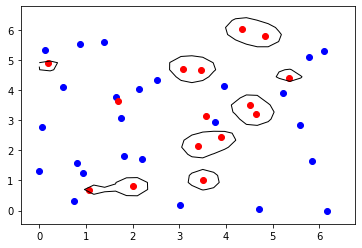

,x,y,label,pred_g
40,3.832743,1.884956,0.0,0.056688
75,4.021239,4.775221,0.0,0.217949
71,2.450442,5.717699,0.0,0.262947
70,4.963716,5.654867,0.0,-0.181177
69,1.445133,3.330088,0.0,0.339345
66,4.586725,4.963716,0.0,0.250723
64,2.953097,2.324779,0.0,0.120392
62,2.827433,6.220353,0.0,0.262760
61,1.193805,0.879646,0.0,-0.002956
60,5.466371,4.838053,0.0,0.202125


In [62]:
C = 0.5        # hyper-parameter of soft-margin SVM


# load traing dataset as input
data = df_period_train.iloc[:,0:2].values
label = df_period_train["label"].apply(lambda x: x*2-1)
 
#  decide the choice of kernel
kernel_choice = kernel_dict["gaussian"]

a, b = get_laglange_param(t=label, kernel=g_kernel_pr)
draw_contour(X=data,t=label, kernel_func=kernel_choice["func"])

test_pred_g = array([f(array(row), a, label, data, b, kernel_choice["func"]) for row in tqdm(df_period_test.iloc[:,:2].values,total=len(df_period_test))])


df_period_test["pred_g"] = test_pred_g
df_period_test.sort_values("label")

In [63]:
# Accuracy
df_period_test.apply(lambda x: (x["label"]==1 and x["pred_g"]>0) or (x["label"]==0 and x["pred_g"]<0),axis=1).sum()/len(df_period_test)

0.575

## Quantume Ver

## Scratch

In [64]:
q_kernel_pr = []
for ind, row in tqdm(df_period_train.iterrows(),total=len(df_period_train)):
    q_kernel_pr.append([quantum_kernel(row[:2].values, row_in[:2].values) for ind_in, row_in in df_period_train.iterrows()])
q_kernel_pr =  np.array(q_kernel_pr)

In [65]:
C = 0.5        # hyper-parameter of soft-margin SVM

# load traing dataset as input
data = df_period_train.iloc[:,0:2].values
label = df_period_train["label"].apply(lambda x: x*2-1)
 
# decide the choice of kernel
kernel_choice = kernel_dict["quantum"]

a, b = get_laglange_param(t=label, kernel=q_kernel_pr)
# draw_contour(X=data,t=label, kernel_func=kernel_choice["func"])
test_pred_q = array([f(array(row), a, label, data, b, kernel_choice["func"]) for row in tqdm(df_period_test.iloc[:,:2].values,total=len(df_period_test))])


df_period_test["pred_q"] = test_pred_q
df_period_test.sort_values("label")

     pcost       dcost       gap    pres   dres
 0: -2.2263e+01 -4.7696e+01  3e+02  5e+00  4e-16
 1: -1.1932e+01 -3.8638e+01  3e+01  7e-16  5e-16
 2: -1.3325e+01 -1.5805e+01  2e+00  2e-16  5e-16
 3: -1.4025e+01 -1.4507e+01  5e-01  1e-16  4e-16
 4: -1.4205e+01 -1.4307e+01  1e-01  2e-16  4e-16
 5: -1.4238e+01 -1.4269e+01  3e-02  4e-16  5e-16
 6: -1.4251e+01 -1.4255e+01  4e-03  2e-16  4e-16
 7: -1.4253e+01 -1.4253e+01  7e-05  9e-16  4e-16
 8: -1.4253e+01 -1.4253e+01  7e-07  4e-16  4e-16
Optimal solution found.
Lagrange Param
[4.99999997e-01 4.99999997e-01 4.99998454e-01 3.14306906e-07
 4.99999995e-01 1.03811481e-07 4.99999961e-01 4.99999997e-01
 7.87229481e-08 1.05246256e-01 4.68250770e-08 4.99999965e-01
 2.62786683e-01 4.99999996e-01 4.99999994e-01 4.99999997e-01
 4.99999996e-01 4.99999997e-01 4.99999802e-01 4.99999885e-01
 3.29576499e-01 9.06966943e-08 4.99999896e-01 4.59669410e-02
 2.53552138e-07 4.99999996e-01 4.99999869e-01 4.99999996e-01
 4.99999996e-01 4.99999978e-01 2.83502923e-01

,x,y,label,pred_g,pred_q
40,3.832743,1.884956,0.0,0.056688,0.200710
75,4.021239,4.775221,0.0,0.217949,0.479167
71,2.450442,5.717699,0.0,0.262947,0.041888
70,4.963716,5.654867,0.0,-0.181177,0.544535
69,1.445133,3.330088,0.0,0.339345,-0.288935
66,4.586725,4.963716,0.0,0.250723,0.349674
64,2.953097,2.324779,0.0,0.120392,0.515607
62,2.827433,6.220353,0.0,0.262760,0.423320
61,1.193805,0.879646,0.0,-0.002956,0.475110
60,5.466371,4.838053,0.0,0.202125,0.230873


In [66]:
# Accuracy
df_period_test.apply(lambda x: (x["label"]==1 and x["pred_q"]>0) or (x["label"]==0 and x["pred_q"]<0),axis=1).sum()/len(df_period_test)

0.425

## library 使用

In [67]:
feature_dim=2
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
qsvm = QSVM(feature_map, training_input_pr, test_input_pr, lambda2=0.2)
result = qsvm.run(quantum_instance)
print(result["testing_accuracy"])
# qsvm.predict(split_dataset_to_data_and_labels(test_input_pr)[0][0])

0.5


/Users/y.n./.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/qiskit/aqua/algorithms/classifiers/qsvm/_qsvm_binary.py:109: ComplexWarning: Casting complex values to real discards the imaginary part
  predicted_labels = binarized_predictions.astype(int)
